In [1]:
! git clone https://github.com/jaumejp/ai-counter.git
%cd ai-counter
! pip install ultralytics
! ls

Cloning into 'ai-counter'...
remote: Enumerating objects: 658, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 658 (delta 4), reused 23 (delta 4), pack-reused 635
Receiving objects: 100% (658/658), 256.26 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (650/650), done.
/content/ai-counter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using 

#### Import necessary libraries

In [2]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

#### Make inference for all images
- images has to be sorted by frame name

In [3]:
model = YOLO('./model/raw/yolov8n.pt')
imgs = './data/frames/'

inference = model(imgs)


image 1/644 /content/ai-counter/data/frames/0.png: 384x640 (no detections), 330.1ms
image 2/644 /content/ai-counter/data/frames/1.png: 384x640 (no detections), 253.6ms
image 3/644 /content/ai-counter/data/frames/10.png: 384x640 (no detections), 313.2ms
image 4/644 /content/ai-counter/data/frames/100.png: 384x640 1 sports ball, 350.5ms
image 5/644 /content/ai-counter/data/frames/101.png: 384x640 1 sports ball, 241.2ms
image 6/644 /content/ai-counter/data/frames/102.png: 384x640 1 sports ball, 344.5ms
image 7/644 /content/ai-counter/data/frames/103.png: 384x640 1 sports ball, 312.3ms
image 8/644 /content/ai-counter/data/frames/104.png: 384x640 1 sports ball, 245.3ms
image 9/644 /content/ai-counter/data/frames/105.png: 384x640 (no detections), 337.1ms
image 10/644 /content/ai-counter/data/frames/106.png: 384x640 (no detections), 387.6ms
image 11/644 /content/ai-counter/data/frames/107.png: 384x640 (no detections), 332.0ms
image 12/644 /content/ai-counter/data/frames/108.png: 384x640 (no 

#### Make a data structure to organize detections for each frame

In [4]:
len(os.listdir('./data/frames/')), len(inference)

(644, 644)

In [5]:
inference[3].path

'/content/ai-counter/data/frames/100.png'

In [6]:
'/content/piece-counter-ai/data/frames/100.png'.split('.')[0].split('/')[-1]

'100'

In [7]:
inference[3].boxes.data

tensor([[9.3613e+02, 0.0000e+00, 1.1466e+03, 6.1115e+01, 2.8845e-01, 3.2000e+01]])

In [8]:
inference[400].boxes.data.cpu().detach().numpy()

array([[     1345.7,      467.78,      1602.2,      713.25,     0.87568,          47],
       [     955.75,      426.83,      1240.1,      713.28,       0.771,          47],
       [      759.4,      494.32,      995.26,      741.61,     0.76221,          47],
       [     988.62,      660.64,      1272.6,      897.68,     0.74682,          47],
       [     1208.6,      595.73,      1371.4,      836.07,      0.6057,          47],
       [     891.94,      320.09,      1146.9,       515.8,     0.59669,          47],
       [     749.05,      318.14,      1371.3,      905.29,     0.52567,          47],
       [     750.94,      320.02,      1246.4,      732.54,     0.27846,          47]], dtype=float32)

In [9]:
data = []

for item in inference:
    data_boxes = item.boxes.data

    # Convert from tensor to numpy array
    data_boxes_np = data_boxes.cpu().detach().numpy()

    data.append({
      'img_id': item.path.split('.')[0].split('/')[-1],
      'apple_detections': data_boxes_np.tolist()
    })


predicts = pd.DataFrame(data)
predicts['img_id'] = predicts['img_id'].astype(int)
predicts

,img_id,apple_detections
0,0,[]
1,1,[]
2,10,[]
3,100,"[[936.125244140625, 0.0, 1146.6456298828125, 6..."
4,101,"[[928.1017456054688, 0.0, 1149.207763671875, 6..."
...,...,...
639,95,[]
640,96,[]
641,97,[]
642,98,[]


#### Sort by the img_id because it would be the natural order of the video

In [10]:
predicts = predicts.sort_values(by='img_id').reset_index(drop=True)
predicts.head()

,img_id,apple_detections
0,0,[]
1,1,[]
2,2,[]
3,3,[]
4,4,[]


#### Get centers

In [11]:
def get_centers_of(detections):
    centers_list = []

    for detection in detections:
        x1 = detection[0]
        y1 = detection[1]
        x2 = detection[2]
        y2 = detection[3]

        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        centers_list.append((center_x, center_y))

    return centers_list

predicts['centers'] = predicts['apple_detections'].apply(lambda cell: get_centers_of(cell))
predicts

,img_id,apple_detections,centers
0,0,[],[]
1,1,[],[]
2,2,[],[]
3,3,[],[]
4,4,[],[]
...,...,...,...
639,639,"[[721.6766967773438, 556.0540161132812, 1046.4...","[(884.0771179199219, 706.7345886230469), (532...."
640,640,"[[721.6305541992188, 555.8899536132812, 1046.4...","[(884.0561828613281, 706.5572814941406), (532...."
641,641,"[[720.9010620117188, 552.8545532226562, 1045.9...","[(883.4153137207031, 703.5478820800781), (1347..."
642,642,"[[720.8604125976562, 549.4281616210938, 1045.3...","[(883.0893859863281, 700.8463134765625), (1348..."


#### Paint frames

In [12]:
def plot_frame(frame):
    pilImg = Image.open(f"./data/frames/{frame.img_id}.png")
    imgdrw = ImageDraw.Draw(pilImg)

    for i in range(len(frame.apple_detections)):
        box = frame.apple_detections[i]
        b1 = tuple(box[0:2])
        b4 = tuple(box[2:4])
        imgdrw.rectangle([b1, b4], outline = 'red', width = 2)

        # Center
        x1, y1 = b1
        x2, y2 = b4
        center_x = frame.centers[i][0]
        center_y = frame.centers[i][1]
        imgdrw.regular_polygon((center_x, center_y, 10), 40, rotation=0, fill='red', outline=None)


    # Add two horizontal lines (beginning and end of the tracking)
    line_y1 = int(0.20 * pilImg.height)
    line_y2 = int(0.25 * pilImg.height)

    imgdrw.line([(0, line_y1), (pilImg.width, line_y1)], fill='blue', width=10)
    imgdrw.line([(0, line_y2), (pilImg.width, line_y2)], fill='blue', width=10)

    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

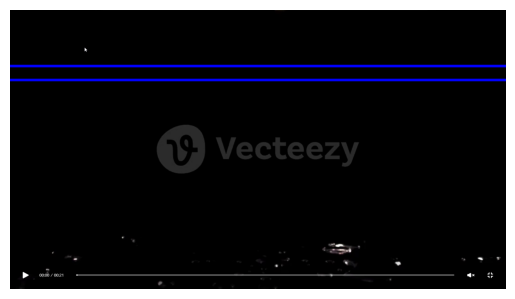

In [13]:
plot_frame(predicts.iloc[0])

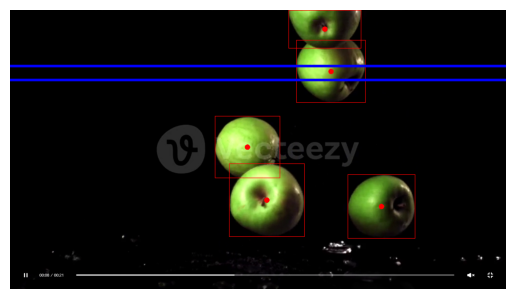

In [14]:
plot_frame(predicts.iloc[360])

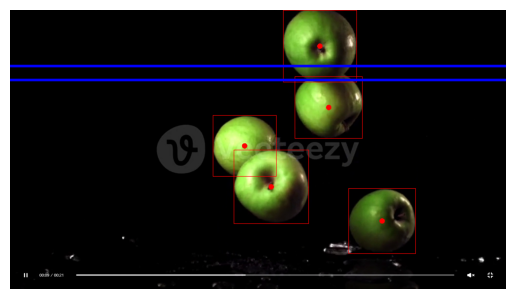

In [15]:
plot_frame(predicts.iloc[380])

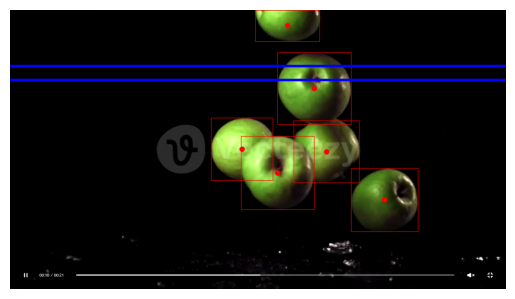

In [16]:
plot_frame(predicts.iloc[400])

#### There are only 7 apples in total; let's check the detections with 8, 9, or 10
- In some frames, the model detects more elements than actually exist.
- This is because the apples are very close.
- Since our algorithm only considers apples only within the range of the blue lines, it dosen't affect us.

In [17]:
predicts['len_predicts'] = predicts.centers.apply(lambda x: len(x))
predicts[predicts['len_predicts'] > 9]

,img_id,apple_detections,centers,len_predicts
482,482,"[[880.762451171875, 0.0, 1198.5435791015625, 1...","[(1039.6530151367188, 89.87142181396484), (148...",10
483,483,"[[878.0533447265625, 0.0, 1196.9056396484375, ...","[(1037.4794921875, 93.0608901977539), (1482.62...",10
484,484,"[[875.7850341796875, 0.0, 1195.7288818359375, ...","[(1035.7569580078125, 98.29568481445312), (148...",10
485,485,"[[873.7620849609375, 0.0, 1194.916259765625, 2...","[(1034.3391723632812, 101.94181823730469), (14...",10


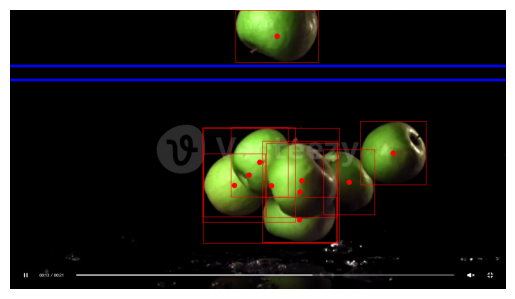

In [18]:
plot_frame(predicts.iloc[485])

#### Algorithm for counting fallen apples
- We look at the centers that fall within the area where we consider they should pass to increase the counter.

- This area is smaller than the height of the element (an apple), so two apples cannot pass through the same x-coordinate at the same time.

- We store all these centers (coordinates) in a list.

- We check if this x-coordinate already exists in the list of previous centers (considering the tolerance for x. This is the value that can fluctuate from one frame to another).

- If we don't have this x-coordinate recorded in the previous array, it means it is a new detection.

- After examining each frame, we assign the previous centers array to the current iteration's array.







In [19]:
pilImg = Image.open(f"./data/frames/0.png")
line_y1 = int(0.20 * pilImg.height)
line_y2 = int(0.25 * pilImg.height)
line_y1, line_y2

(216, 270)

In [20]:
predict_row_1 = pd.DataFrame(predicts.iloc[360]).transpose()
predict_row_2 = pd.DataFrame(predicts.iloc[380]).transpose()
predict_row_3 = pd.DataFrame(predicts.iloc[400]).transpose()

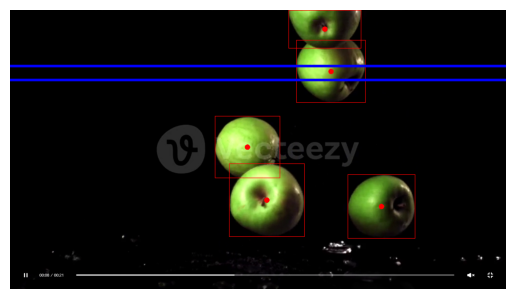

In [21]:
plot_frame(predicts.iloc[360])

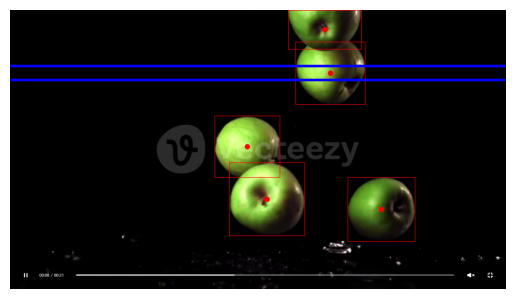

In [22]:
plot_frame(predicts.iloc[361])

In [24]:
predict_row_1 = pd.DataFrame(predicts.iloc[360]).transpose()
predict_row_2 = pd.DataFrame(predicts.iloc[361]).transpose()

combined_predicts = pd.concat([predict_row_1, predict_row_2])

In [25]:
# helper functions

def index_closest_to_n(array, n):
    min = abs(array[0][0] - n)
    closest_index = 0

    for i in range(len((array))):
        new_range = abs(array[i][0] - n)

        if new_range < min:
            min = new_range
            closest_index = i

    return closest_index

tuples_array = [(10, 10), (80, 20), (60, 30)]
n = 4
index = index_closest_to_n(tuples_array, n)
print("The index of the tuple closest to", n, "in the original array is:", index)

The index of the tuple closest to 4 in the original array is: 0


In [26]:
array1 = [(10, 20), (30, 40), (50, 60)]
array2 = [(9, 70), (35, 80), (55, 90)]

tolerance = 3

def within_tolerance(x, array1, tolerance):
    for x1, _ in array1:
        if abs(x1 - x) <= tolerance:
            return True
    return False

for x, _ in array2:
    if within_tolerance(x, array1, tolerance):
        print(f"The value x={x} of 2nd array is on tolerance of 1st array")
    else:
        print(f"The value x={x} of 2nd array is NOT on tolerance of 1st array")


The value x=9 of 2nd array is on tolerance of 1st array
The value x=35 of 2nd array is NOT on tolerance of 1st array
The value x=55 of 2nd array is NOT on tolerance of 1st array


In [27]:
prev_centers = []
current_centers = []

apple_counter = 0

tolerance = 3 # px

for idx, row in predicts.iterrows():
    current_centers = []

    for center in row.centers:
        if center[1] >= line_y1 and center[1] <= line_y2:
            current_centers.append(center)

    # Check if any detection is in the previous frame
    # If not it means a new detection
    for x, _ in current_centers:
        if not within_tolerance(x, prev_centers, tolerance):
            apple_counter += 1

    prev_centers = current_centers.copy()

apple_counter


7